In [1]:
using Pkg
Pkg.activate("SchrodingerEquationSolver")

  Activating new project at `~/Desktop/physics_coding_projects/julia/SchrodingerEquationSolver/src/SchrodingerEquationSolver`


In [2]:

using Plots

import("Grids.jl");
#using .Grids;
include("Potentials.jl")
using .Potentials;
include("Hydrogen.jl")
using .Hydrogen;


include("IntegralNumericalMethods.jl");
using .IntegralNumericalMethods;

include("MathUtils.jl")
using .MathUtils


In [3]:
r_min::Float32=1.0e-8;
r_max::Float32=10.0;
N::Int32=10000;
l::Int32=1;
Z::Int32=1;
w::Float32=1;
m::Float32=1;


In [4]:
#grid= Grids.uniform_grid(r_min, r_max, N);
grid= Grids.exponential_grid(r_max, Z);

In [5]:
length(grid)

6360

In [6]:
v_angu= Potentials.angular_potential(l, grid);
v_colu= Potentials.coulomb_potential(Z, grid);
v_harm= Potentials.harmoic_oscilator_potential(w, m, grid);

In [7]:
u_s1_hydr= Hydrogen.u_s1_hydrogen(grid);

In [8]:
E::Float32= -0.5000;
l::Int32=0;
init_valu1_fwrd::Float32=u_s1_hydr[1];#grid[1]^(l+1.0)
init_valu2_fwrd::Float32=u_s1_hydr[2];#grid[2]^(l+1.0)
init_valu1_bwrd::Float32=u_s1_hydr[end];#grid[1]^(l+1.0)
init_valu2_bwrd::Float32=u_s1_hydr[end-1];#grid[2]^(l+1.0)
v_effe= v_colu;
f::Vector{Float32}= 2.0.*(v_effe .- E);
#given f find the classical turning points
g=zeros(Float32, size(f)[1]);



In [9]:
#find turn_pnts of of f, basically the clasical turning points of the effective density_potential
#with restepect to the E proposed eigenvalue
turn_pnts= MathUtils.turning_points_indices(f);
if length(turn_pnts) ==  0
    throw(DomainError("the effective potential has no turning points 
    for the proposed energy eigenvalue, this means v_effe - E has no zeroes"));
end


In [10]:
#do forward integration of radial shcrodinger equation u
u_fwd= IntegralNumericalMethods.integrate_second_order_DE(grid,g,f,
                                                            init_valu1_fwrd,init_valu2_fwrd);
#do backward integreation of the radial shcrodinger equation u 
u_bwd= reverse(IntegralNumericalMethods.integrate_second_order_DE(reverse(grid),g,reverse(f),
                init_valu1_bwrd,init_valu2_bwrd));
#rescale u_fwd, u_bwd to make u_fwd[turn_pnts[1]] = u_bwd[turn_pnts[1]]
u_fwd, u_bwd= MathUtils.rescale!(u_fwd, u_bwd, turn_pnts[1]);
#merge solutions
u_merged, merge_value= MathUtils.merge_solutions(u_fwd, u_bwd, grid, turn_pnts[1]);



In [11]:
merge_value

-6.467104f-6

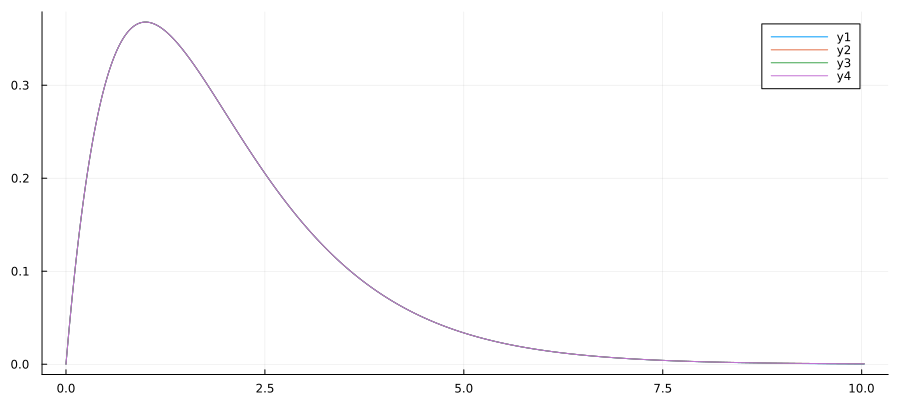

In [12]:
plot(grid, [u_fwd, u_bwd, u_merged, u_s1_hydr])
plot!(size=(900,400))

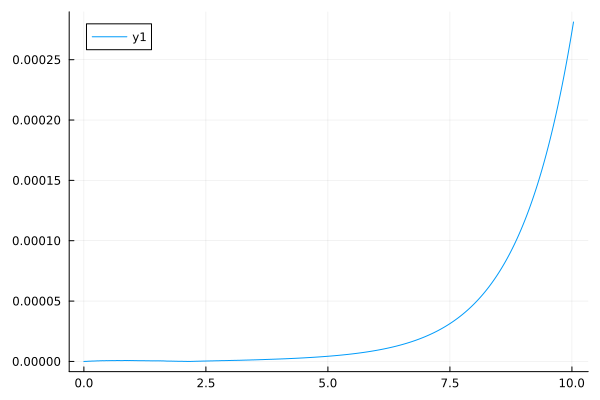

In [24]:
plot(grid, ((u_fwd .- u_s1_hydr).^2).^0.5)

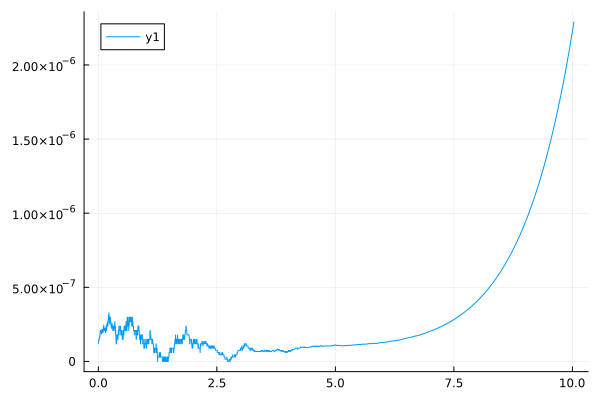

In [25]:
plot(grid, ((u_bwd .- u_s1_hydr).^2).^0.5)

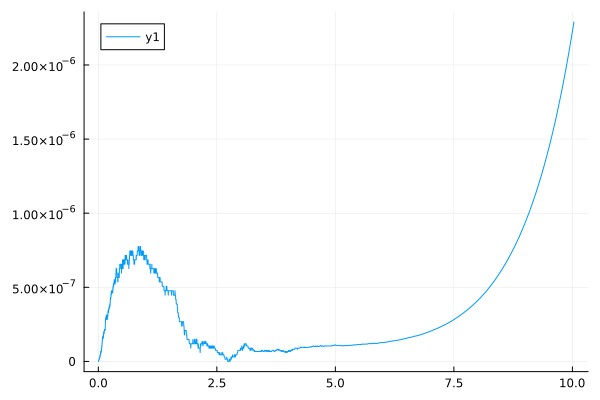

In [26]:
plot(grid, ((u_merged .- u_s1_hydr).^2).^0.5)

In [28]:
temp= ((u_merged .- u_s1_hydr).^2).^0.5;

In [33]:
sum(temp)/length(temp)

1.3244958244185126e-7

In [34]:
sum(temp)/length(temp) < 1.325e-7

true

In [ ]:
include("tests/tests_u_s1_hydrogen")

In [31]:
#parameters needed to solve equation
E= -0.5000;
l=0;
v_effe= v_colu;
y_1=u_s1_hydr[1];#grid[1]^(l+1.0)
y_2=u_s1_hydr[2];#grid[2]^(l+1.0)
grid=grid;
g0=zeros(Float32, 6)
g1=zeros(Float32, 6)
f0=ones(Float32, 6)
f1= 2.0.*(v_effe .- E);

N=size(v_effe)[1];

y0=zeros(Float32, N);#solution to differential equation
y1=zeros(Float32, N);#first derivative of solution to differential equation
y0[1]= y_1;
y1[1]= (y_2 - y_1)/(grid[2]-grid[1]);

for i in 1:4
#for i in 1:(N-1)
    h= grid[i+1] - grid[i];
    y0[i+1], y1[i+1]= IntegralNumericalMethods.RK4(g1,f1[i:i+1],y0[i], y1[i],h);
end
#integration loop using prediction correction adams moulton degree 5
for i in 6:N
    h= grid[i] - grid[i-1];
    y0[i], y1[i]= IntegralNumericalMethods.PCABM5(g1,f1[i-5:i],
                                            y0[i-5:i-1], y1[i-5:i-1],h);
end

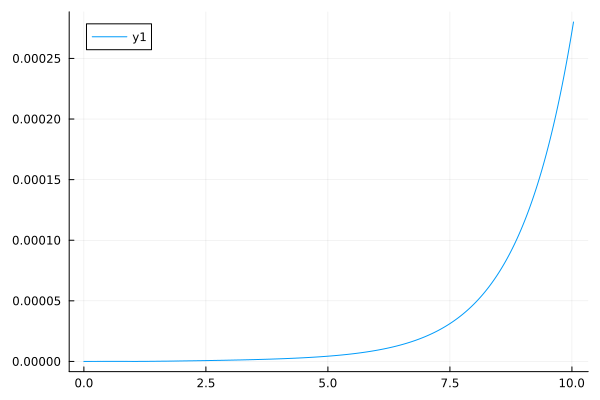

In [32]:
plot(grid, ((y0 .- u_s1_hydr).^2).^0.5)

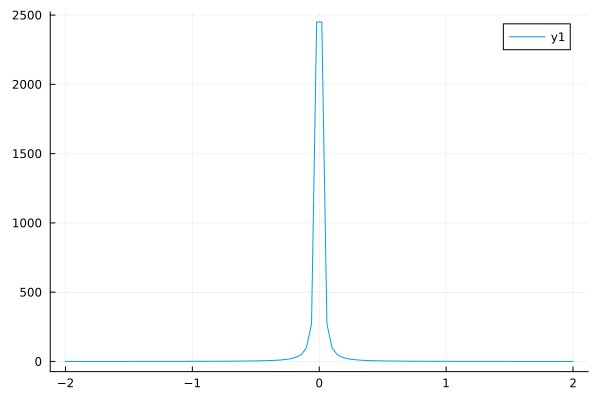

In [5]:
plot(unif_grid, v_angu)

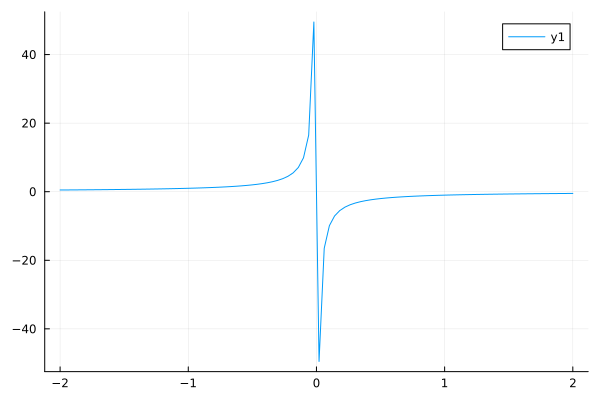

In [6]:
plot(unif_grid, v_colu)

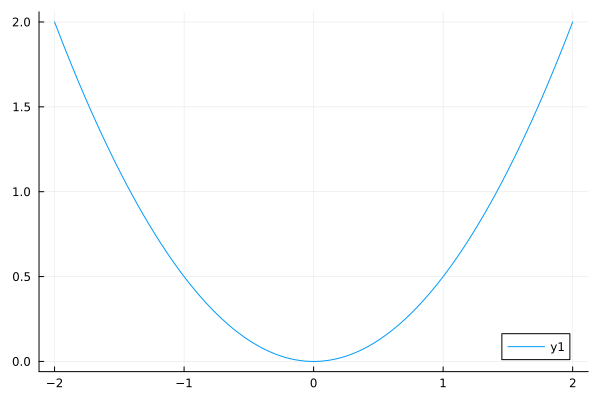

In [7]:
plot(unif_grid, v_harm)